In [323]:
%pylab inline
from sklearn.datasets import load_boston, load_digits
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

from scipy import stats

from pprint import pprint as pp

Populating the interactive namespace from numpy and matplotlib


In [335]:
boston = load_boston()
data = np.random.rand(boston.data.shape[0], boston.data.shape[1] * 5)

correct_indices = []
random_indices = np.arange(65)
for i in range(boston.data.shape[1]):
    data[:, i*5+1] *= 2
    data[:, i*5+2] **= 2
    data[:, i*5+4] += 5
    data[:, i*5] = boston.data[:, i]
    correct_indices.append(i*5)

correct_indices = np.array(correct_indices) 
random_indices = list(set(random_indices) - set(correct_indices))
random_indices.sort()

train_x, test_x, train_y, test_y = train_test_split(data, 
                                                    boston.target.reshape(-1, 1),
                                                    test_size=0.3)

print('Random Indices:', random_indices)
print('Correct Indices:', correct_indices)
print('train x:', train_x.shape)
print('train y:', train_y.shape)

Random Indices: [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64]
Correct Indices: [ 0  5 10 15 20 25 30 35 40 45 50 55 60]
train x: (354, 65)
train y: (354, 1)


# Pearson Correlation

[60]    0.736 [Correct]
[25]   0.7227 [Correct]
[10]   0.5005 [Correct]
[50]   0.4925 [Correct]
[45]   0.4574 [Correct]
[20]    0.447 [Correct]
[30]   0.4169 [Correct]
[5 ]   0.3904 [Correct]
[40]   0.3616 [Correct]
[0 ]   0.3577 [Correct]
[55]   0.3318 [Correct]
[35]   0.2596 [Correct]
[15]   0.1692 [Correct]
[49]   0.1559
[21]   0.1193
[46]   0.1093
[57]   0.1075
[11]   0.1016
[27]  0.09906
[42]  0.09307
[18]  0.09301
[33]  0.07854
[32]  0.07374
[44]  0.07269
[1 ]   0.0673
[19]   0.0646
[51]  0.06454
[52]  0.06183
[62]  0.05942
[39]  0.05496
[16]  0.04698
[7 ]   0.0436
[24]  0.04207
[61]  0.03953
[17]   0.0367
[41]  0.03401
[2 ]  0.03377
[14]  0.03078
[9 ]  0.03058
[29]  0.03028
[38]  0.02999
[64]  0.02747
[59]  0.02662
[26]  0.02654
[13]  0.02583
[23]  0.02227
[8 ]  0.02155
[58]  0.02118
[36]  0.02094
[28]  0.01973
[4 ]  0.01536
[47]  0.01492
[43]  0.01464
[34]  0.01457
[53]   0.0145
[56]  0.01441
[63]  0.01338
[3 ] 0.008078
[22] 0.007799
[37] 0.006356
[54] 0.005356
[31] 0.004746
[6

<Container object of 52 artists>

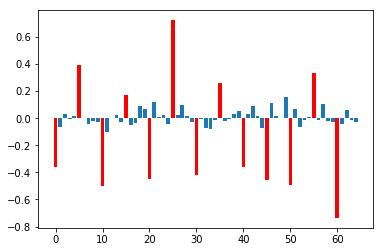

In [336]:
# Calculate Pearson Correlation
correlations = []
for i in range(train_x.shape[1]):
    c = np.corrcoef(train_x[:, i], train_y.reshape(-1))[0, 1]
    t = stats.ttest_1samp(train_y.reshape(-1), c)
    correlations.append((i, c))
correlations = np.array(correlations)


sorted_corrs = sorted(correlations, key=lambda x: -abs(x[1]))
for i, c in  sorted_corrs:
    i = int(i)
    c = abs(c)
    if i in correct_indices:
        print(f'[{i:<2}] {c:8.4} [Correct]')
    else:
        print(f'[{i:<2}] {c:8.4}')

bar(correct_indices, correlations[:, 1][correct_indices], color='red')
bar(random_indices, correlations[:, 1][random_indices])

# Tools

In [51]:
def show_result(y_true, y_pred, sample=30):
    print('R^2:', r2_score(y_true, y_pred))
    print('MSE:', mean_squared_error(y_true, y_pred))
    n = y_pred.shape[0]
    
    fig, plots = subplots(2, 2)
    plots = plots.reshape(-1)
    for p  in plots:
        idx = np.random.randint(0, n-sample)
    
        p.plot(y_true[idx: idx+sample])
        p.plot(y_pred[idx: idx+sample], color='red')

# Lasso Regression

R^2: 0.600629398728
MSE: 28.1705538313


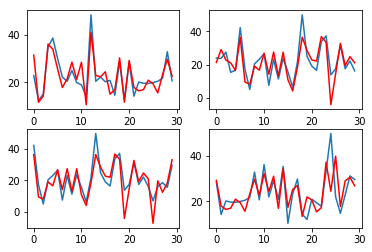

In [85]:
lasso = Lasso(alpha=0.01)
lasso.fit(train_x, train_y)
pred_y = lasso.predict(test_x)

show_result(test_y, pred_y)

<Container object of 52 artists>

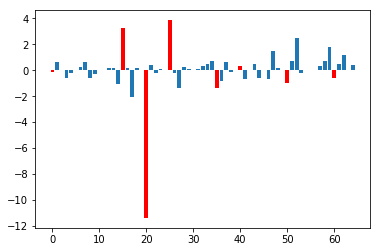

In [280]:
bar(correct_indices, lasso.coef_[correct_indices], color='red')
bar(random_indices, lasso.coef_[random_indices])

# Ridge Regression

R^2: 0.599493450941
MSE: 30.9553007773


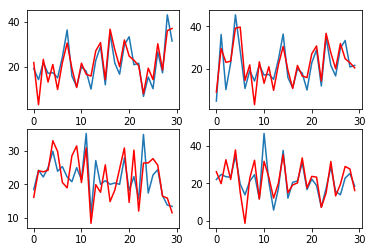

In [260]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_x, train_y)
pred_y = ridge.predict(test_x)

show_result(test_y, pred_y)

[]

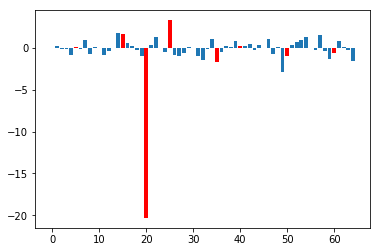

In [265]:
coef = ridge.coef_[0]
bar(correct_indices, coef[correct_indices], color='red')
bar(random_indices, coef[random_indices])
plot()

# Convolution Neural Network

In [231]:
# Scalers
scaler = MinMaxScaler()
scaler.fit(data)
target_scaler = MinMaxScaler()
target_scaler.fit(boston.target.reshape(-1, 1))

# Scaling
dl_train_x = scaler.transform(train_x).reshape(-1, 65, 1)
dl_train_y = target_scaler.transform(train_y)
dl_test_x = scaler.transform(test_x).reshape(-1, 65, 1)
dl_test_y = target_scaler.transform(test_y)

R^2: 0.45001323597
MSE: 0.019208308776


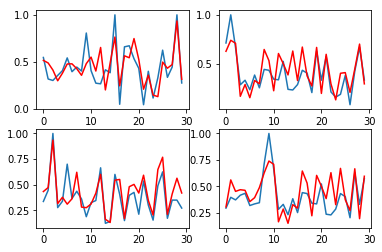

In [239]:
cnn = Sequential()
cnn.add(Conv1D(filters=256, kernel_size=12, strides=1, input_shape=(65, 1), activation='relu'))
cnn.add(Conv1D(filters=156, kernel_size=6, strides=1, activation='relu'))
cnn.add(Conv1D(filters=97, kernel_size=5, strides=1, activation='relu'))
cnn.add(Conv1D(filters=64, kernel_size=4, strides=1, activation='relu'))
cnn.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu'))
cnn.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu'))
cnn.add(Conv1D(filters=16, kernel_size=1, strides=1, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

cnn.fit(dl_train_x, dl_train_y, verbose=0, epochs=500)
dl_pred_y = cnn.predict(dl_test_x).reshape(-1, 1)

show_result(dl_test_y, dl_pred_y)

# Deep Neural Network

In [182]:
dl_train_x = dl_train_x.reshape(-1, 65)
dl_test_x = dl_test_x.reshape(-1, 65)

R^2: 0.73244442359
MSE: 0.00934438874269


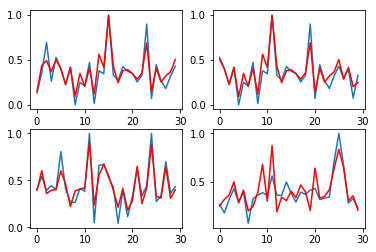

In [198]:
dnn = Sequential()
dnn.add(Dense(512, batch_input_shape=(None, 65)))
dnn.add(Activation('relu'))

dnn.add(Dense(512))
dnn.add(Activation('relu'))

dnn.add(Dense(456))
dnn.add(Activation('relu'))

dnn.add(Dense(345))
dnn.add(Activation('relu'))

dnn.add(Dense(256))
dnn.add(Activation('relu'))

dnn.add(Dense(128))
dnn.add(Activation('relu'))

dnn.add(Dense(128))
dnn.add(Activation('relu'))

dnn.add(Dense(64))
dnn.add(Activation('relu'))

dnn.add(Dense(1, activation='sigmoid'))
dnn.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

dnn.fit(dl_train_x, dl_train_y, verbose=0, epochs=200)
pred_y = dnn.predict(dl_test_x).reshape(-1, 1)

show_result(dl_test_y, pred_y)